# <center> <span style="font-family: Virgil GS, sans-serif; color:#97f788">Neural Networks</span> </center>
## <center> <span style="font-family: Virgil GS, sans-serif; color:navyblue">RNN for transactions (PD)</span> </center>

 <span style="font-family: Virgil GS, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

## Transactions

In [1]:
# sourcery skip: remove-redundant-fstring
import pandas as pd
import numpy as np

# https://data.world/lpetrocelli/czech-financial-dataset-real-anonymized-transactions
dataset_path = (
    f"/Users/deburky/Documents/python/data/"
    f"lpetrocelli-czech-financial-dataset-real-anonymized-transactions/data"
)

dataset_trans = pd.read_csv(f"{dataset_path}/trans.csv")

dict_to_rename = {
    "VYDAJ": "EXPENSE",
    "PRIJEM": "INCOME",
    "VYBER": "WITHDRAWAL",
    "VYBER KARTOU": "CARD_WITHDRAWAL",
    "PREVOD NA UCET": "TRANSFER_TO_ACCOUNT",
    "PREVOD Z UCTU": "TRANSFER_FROM_ACCOUNT",
    "VKLAD": "DEPOSIT",
}

dataset_trans["type"] = dataset_trans["type"].map(
    dict_to_rename
)
dataset_trans["operation"] = dataset_trans["operation"].map(
    dict_to_rename
)
dataset_trans["operation"] = np.where(
    dataset_trans["operation"].isna(),
    "TRANSFER_TO_ACCOUNT",
    dataset_trans["operation"],
)


# convert date lookin like 930101 to 1993-01-01
def convert_date(date):
    date = str(date)
    year = int(f"19{date[:2]}")
    month = int(date[2:4])
    day = int(date[4:])
    return pd.Timestamp(year=year, month=month, day=day)


dataset_trans["date"] = dataset_trans["date"].apply(
    convert_date
)

dataset_trans["amount"] = np.where(
    dataset_trans["type"] == "EXPENSE",
    -dataset_trans["amount"],
    dataset_trans["amount"],
)

dataset_trans["amount_to_balance"] = (
    abs(dataset_trans["amount"]) / dataset_trans["balance"]
)
dataset_trans["amount_balance_interaction"] = (
    dataset_trans["amount"] * dataset_trans["balance"]
)

dataset_trans.drop(
    columns=["k_symbol", "bank", "account"], inplace=True
)

/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_746/1137033610.py:11: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_trans = pd.read_csv(f"{dataset_path}/trans.csv")


In [2]:
# remove rows with account_id having less than a series of 10 transactions
dataset_trans_trx = dataset_trans.groupby(
    "account_id"
).filter(lambda x: len(x) > 10)

## Labels

In [3]:
dataset_default = pd.read_csv(f"{dataset_path}/loan.csv")

bad_labels = ["B", "D"]

dataset_default["default_label"] = np.where(
    dataset_default["status"].isin(bad_labels), 1, 0
)

defaults = dataset_default.query("default_label == 1")

# convert date to datetime
defaults["date"] = defaults["date"].apply(convert_date)

/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_746/1079541685.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defaults["date"] = defaults["date"].apply(convert_date)


In [4]:
default_rate = dataset_default["default_label"].mean()
print(f"Default rate: {default_rate:.2%}")

Default rate: 11.14%


## Training data

In [5]:
# please keep only account_id in dataset_trans which is present in dataset_default
list_of_ids = dataset_default["account_id"].unique()
dataset_trans_filtered = dataset_trans_trx[
    dataset_trans_trx["account_id"].isin(list_of_ids)
]

training_data = pd.merge_asof(
    dataset_trans_filtered,
    defaults[["account_id", "date", "default_label"]],
    by="account_id",
    on="date",
    direction="backward",
)

training_data["default_label"] = (
    training_data["default_label"].fillna(0).astype(int)
)

### Sequence transformation

In [6]:
# keep only data starting from 1994
print(len(training_data))
training_data = training_data.query(
    "date >= '1994-01-01'"
).copy()
print(len(training_data))
training_data.sort_values(
    ["account_id", "date", "trans_id"], inplace=True
)

191556
186907


In [7]:
# calculate for each account ID difference in balance between two consecutive transactions
training_data["balance_delta"] = training_data.groupby(
    "account_id"
)["balance"].diff()
training_data["balance_delta"] = np.where(
    training_data["balance"].isna(),
    0,
    training_data["balance"],
)

<Axes: xlabel='date'>

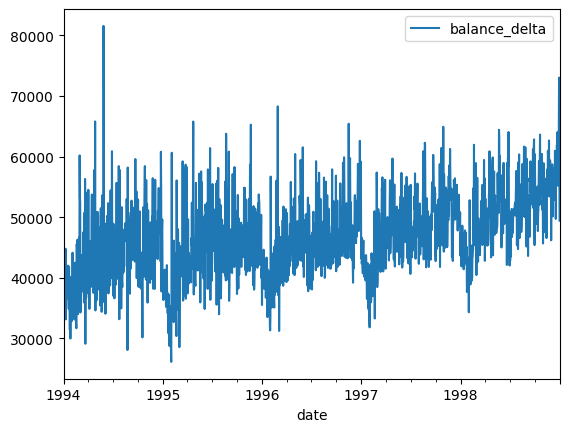

In [8]:
training_data.groupby("date").agg(
    {"balance_delta": "mean"}
).plot()

## RNN

### Dataset Class (AccountSequenceDataset)

**Purpose**: Prepares and handles sequences of transactions for each `account_id`.

### Attributes:
- `data`: The original dataset, grouped by `account_id`.
- `max_sequence_length`: The maximum length of sequences.
- `sequences`: A list of sequences (padded if shorter than `max_sequence_length`).
- `labels`: The label (default or not) associated with each sequence.

### Methods:
- `__len__()`: Returns the number of sequences.
- `__getitem__(idx)`: Returns a specific sequence and its label.

### RNN Model (SequentialModel)

**Purpose**: Processes the sequences and produces a prediction for each sequence.

#### Attributes:
- `input_size`: The number of input features (4 in this case: `amount`, `balance`, `amount_to_balance`, `balance_delta`).
- `hidden_size`: The number of hidden units in the RNN.
- `rnn`: The RNN layer which processes the sequences.
- `dropout`: A dropout layer to prevent overfitting.
- `fc`: A fully connected layer that produces the final output.

#### Methods:
- `forward(x)`: Defines the forward pass through the network.

In [14]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

torch.manual_seed(0)

seq_id = "account_id"
features = [
    "amount",
    "balance",
    "amount_to_balance",
    "balance_delta",
]
label = "default_label"


# Define a custom Dataset class to handle sequences
class AccountSequenceDataset(Dataset):
    def __init__(
        self,
        data,
        max_sequence_length=10,
        seq_id="account_id",
    ):
        self.data = data.groupby(seq_id)
        self.max_sequence_length = max_sequence_length
        self.sequences = []
        self.labels = []
        for _, group in self.data:
            if len(group) > max_sequence_length:
                sequence = group[features].values[
                    :max_sequence_length
                ]
            else:
                sequence = np.pad(
                    group[features].values,
                    (
                        (
                            0,
                            max_sequence_length
                            - len(group),
                        ),
                        (0, 0),
                    ),
                )
            self.sequences.append(
                torch.tensor(sequence, dtype=torch.float32)
            )
            self.labels.append(
                torch.tensor(
                    group[label].values[0],
                    dtype=torch.float32,
                )
            )

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]


# Define the RNN model
class SequentialModel(nn.Module):
    def __init__(
        self, input_size, hidden_size, num_classes
    ):
        super(SequentialModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(
            input_size, hidden_size, batch_first=True
        )
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out


# Prepare training and test datasets
X = training_data[features]
A = training_data[seq_id]
y = training_data[label]

training_data_df = pd.concat([X, y, A], axis=1)
ix_train, ix_test = train_test_split(
    training_data_df.index,
    stratify=y,
    test_size=0.3,
    random_state=42,
)

training_data_train = training_data_df.loc[ix_train]
training_data_test = training_data_df.loc[ix_test]

# Perform feature scaling
scaler = StandardScaler()
training_data_train[features] = (
    scaler.fit_transform(training_data_train[features]) * 50
)
training_data_test[features] = (
    scaler.transform(training_data_test[features]) * 50
)

# Create datasets and dataloaders
train_dataset = AccountSequenceDataset(training_data_train)
test_dataset = AccountSequenceDataset(training_data_test)

train_loader = DataLoader(
    train_dataset, batch_size=100, shuffle=False
)
test_loader = DataLoader(
    test_dataset, batch_size=100, shuffle=False
)

# Initialize model, criterion, and optimizer
model = SequentialModel(
    input_size=len(features), hidden_size=64, num_classes=1
)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=1e-5, weight_decay=1e-5
)

# Training loop
losses = []
for epoch in range(4000):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze(1)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss {loss.item():.4f}")

# Make inference on the test set
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch).squeeze(1)
        predictions.extend(torch.sigmoid(outputs).numpy())
        true_labels.extend(y_batch.numpy())

# Calculate performance metric
gini = 2 * roc_auc_score(true_labels, predictions) - 1
print(f"Gini: {gini:.2%}")

Epoch 0, Loss 0.7363
Epoch 100, Loss 0.6588
Epoch 200, Loss 0.6031
Epoch 300, Loss 0.5445
Epoch 400, Loss 0.5565
Epoch 500, Loss 0.5206
Epoch 600, Loss 0.4601
Epoch 700, Loss 0.4603
Epoch 800, Loss 0.4522
Epoch 900, Loss 0.3951
Epoch 1000, Loss 0.3733
Epoch 1100, Loss 0.3282
Epoch 1200, Loss 0.3096
Epoch 1300, Loss 0.2506
Epoch 1400, Loss 0.2576
Epoch 1500, Loss 0.2856
Epoch 1600, Loss 0.2363
Epoch 1700, Loss 0.2767
Epoch 1800, Loss 0.2715
Epoch 1900, Loss 0.2391
Epoch 2000, Loss 0.2496
Epoch 2100, Loss 0.2374
Epoch 2200, Loss 0.2183
Epoch 2300, Loss 0.2010
Epoch 2400, Loss 0.2507
Epoch 2500, Loss 0.2472
Epoch 2600, Loss 0.2232
Epoch 2700, Loss 0.2281
Epoch 2800, Loss 0.2277
Epoch 2900, Loss 0.1953
Epoch 3000, Loss 0.1919
Epoch 3100, Loss 0.2103
Epoch 3200, Loss 0.2020
Epoch 3300, Loss 0.1881
Epoch 3400, Loss 0.1958
Epoch 3500, Loss 0.2073
Epoch 3600, Loss 0.1971
Epoch 3700, Loss 0.1758
Epoch 3800, Loss 0.1888
Epoch 3900, Loss 0.1290
Gini: 56.44%


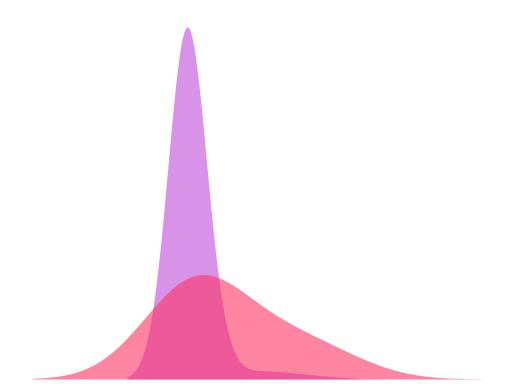

In [15]:
from scipy.special import logit
from matplotlib import pyplot as plt
import seaborn as sns

predictions = np.array(predictions)
y_test = np.array(true_labels)

common_kde_params = dict(
    fill=True,
    alpha=0.6,
    linewidth=0.0,
    bw_method=2.0,
    bw_adjust=0.5,
)
sns.kdeplot(predictions[y_test == 0], label="Non-default", color="#be4bdb", **common_kde_params)  # type: ignore
sns.kdeplot(predictions[y_test == 1], label="Default", color="#fe3465", **common_kde_params)  # type: ignore
plt.axis("off")
plt.show()